# MNIST Uncertainty Plots


This notebook contains the code needed to load in trained SOEN models and use them to make predictions on the test set of the MNIST data. 

- We will look into whether the predictive variance due to flux noise can be used to provide a good estimate of model uncertainty

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


os.chdir(os.path.dirname(os.path.abspath("./")))
print(os.getcwd())


from utils.soen_model_utils import *
from model.model_config import *
from model.soen_model import *
from model_config_files.mnist_config import MNISTConfig
from utils.data_loader import *

/Users/matthewcox/Documents/UCL/MSc/Full_Phen_SOEN


In [2]:


# Global font size variables
TITLE_FONT_SIZE = 30
AXIS_LABEL_FONT_SIZE = 25
TICK_LABEL_FONT_SIZE = 20
SUPTITLE_FONT_SIZE = 30


def load_model(model_path: str) -> SOENModel:
    model = load_soen_model(model_path, SOENModel)
    model.config.activation_function = "gaussian_mixture"
    model.max_iter = 10
    model.config.track_state_evolution = True
    model.config.run_to_equilibrium = False
    model.eval()
    return model

def get_random_mnist_image(test_loader: DataLoader) -> Tuple[torch.Tensor, int, torch.Tensor]:
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    idx = np.random.randint(len(images))
    image, label = images[idx], labels[idx]
    input_values = image.view(1, -1)
    return input_values, label.item(), image

def run_model(model: SOENModel, input_values: torch.Tensor, noise_std: float) -> torch.Tensor:
    model.test_noise_std = noise_std
    model(input_values)
    return model.get_state_evolution().detach()

def get_final_states(state_evolution: torch.Tensor, model: SOENModel) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    final_states = state_evolution[-1, 0, :].cpu().numpy()
    input_states = final_states[:model.num_input]
    hidden_states = final_states[model.num_input:model.num_input + model.num_hidden]
    output_states = final_states[-model.num_output:]
    return input_states, hidden_states, output_states

def setup_plot_style():
    plt.style.use('default')
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']

def plot_histogram(ax, data: np.ndarray, title: str, bins: int = 30, x_label: str = 'State Value'):
    counts, bin_edges, _ = ax.hist(data, bins=bins, color='darkgrey', edgecolor='black')
    ax.set_title(title, fontsize=TITLE_FONT_SIZE, fontweight='bold')
    ax.set_xlabel(x_label, fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('Frequency', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE)

def plot_output_bar(ax, output_states: List[np.ndarray]):
    mean_output = np.mean(output_states, axis=0)
    std_output = np.std(output_states, axis=0)
    output_labels = range(10)
    ax.bar(output_labels, mean_output, color='darkgrey', edgecolor='black', 
           yerr=std_output, capsize=5, ecolor='red')
    ax.set_title('Output Nodes', fontsize=TITLE_FONT_SIZE, fontweight='bold')
    ax.set_xlabel('Digit', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('State Value', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_xticks(output_labels)
    ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE)

def plot_input_image(ax, image: torch.Tensor, label: int):
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Input Image (Label: {label})', fontsize=TITLE_FONT_SIZE, fontweight='bold')
    ax.axis('off')

def print_summary_statistics(input_states: List[np.ndarray], hidden_states: List[np.ndarray], output_states: List[np.ndarray]):
    print("\nSummary Statistics:")
    print(f"Input Nodes: Mean = {np.mean([np.mean(i) for i in input_states]):.4f}, Std = {np.mean([np.std(i) for i in input_states]):.4f}")
    print(f"Hidden Nodes: Mean = {np.mean([np.mean(h) for h in hidden_states]):.4f}, Std = {np.mean([np.std(h) for h in hidden_states]):.4f}")
    print(f"Output Nodes: Mean = {np.mean([np.mean(o) for o in output_states]):.4f}, Std = {np.mean([np.std(o) for o in output_states]):.4f}")

def print_model_prediction(output_states: List[np.ndarray], label: int):
    mean_output = np.mean(output_states, axis=0)
    prediction = mean_output.argmax()
    print(f"\nModel Prediction: {prediction}")
    print(f"Actual Label: {label}")

# Load the trained model

trained_model_path = "/Users/matthewcox/Documents/UCL/MSc/Full_Phen_SOEN/Saved_Models/General_saved_models/ib1.7_gauss_fluxbias_glorot_all_lps.pth"
model_MNIST_Trained = load_model(trained_model_path)

# Load MNIST data
_, _, test_loader = load_mnist_data()



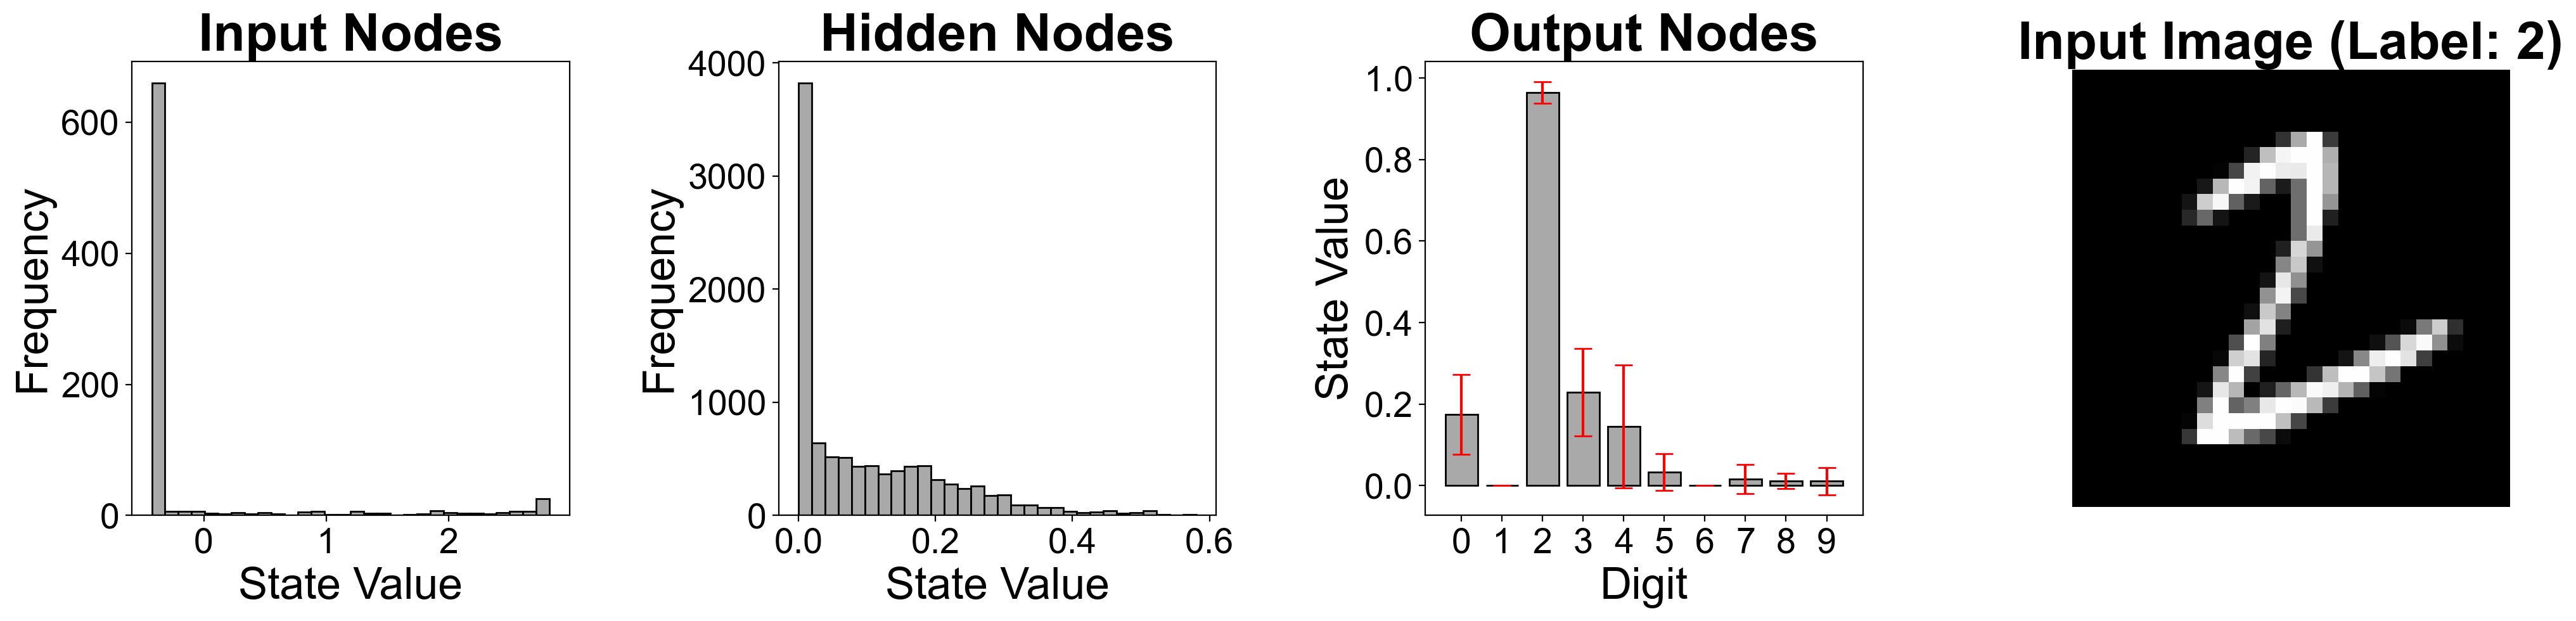


Summary Statistics:
Input Nodes: Mean = -0.1161, Std = 0.8308
Hidden Nodes: Mean = 0.1001, Std = 0.1140
Output Nodes: Mean = 0.1585, Std = 0.2872

Model Prediction: 2
Actual Label: 2


In [3]:
# Get a random MNIST image
input_values, label, original_image = get_random_mnist_image(test_loader)

# Run the model multiple times with different noise levels
num_runs = 10
noise_std = 0.05  

all_input_states = []
all_hidden_states = []
all_output_states = []

for _ in range(num_runs):
    state_evolution = run_model(model_MNIST_Trained, input_values, noise_std)
    input_states, hidden_states, output_states = get_final_states(state_evolution, model_MNIST_Trained)
    all_input_states.append(input_states)
    all_hidden_states.append(hidden_states)
    all_output_states.append(output_states)

# Set up the plot
setup_plot_style()
fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
axs = axs.flatten()

# Plot histograms and bar chart
plot_histogram(axs[0], all_input_states[0], 'Input Nodes', bins=30)
plot_histogram(axs[1], np.concatenate(all_hidden_states), 'Hidden Nodes')
plot_output_bar(axs[2], all_output_states)
plot_input_image(axs[3], original_image, label)

# Adjust layout and display
plt.tight_layout(w_pad=4, h_pad=4)
plt.show()

# Print summary statistics and prediction
print_summary_statistics(all_input_states, all_hidden_states, all_output_states)
print_model_prediction(all_output_states, label)

## Now let's see whether the predictive variance correlates with the loss

In [5]:
import os
from scipy import stats
from typing import Tuple, List, Callable



def load_model(model_path: str) -> SOENModel:
    model = load_soen_model(model_path, SOENModel)
    model.config.activation_function = "gaussian_mixture"
    model.max_iter = 10
    model.config.track_state_evolution = False
    model.config.run_to_equilibrium = False
    model.eval()
    return model

def run_model(model: SOENModel, input_values: torch.Tensor, noise_std: float) -> torch.Tensor:
    model.test_noise_std = noise_std
    model(input_values)
    return model.get_state_evolution().detach()

def get_final_states(state_evolution: torch.Tensor, model: SOENModel) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    final_states = state_evolution[-1, 0, :].cpu().numpy()
    input_states = final_states[:model.num_input]
    hidden_states = final_states[model.num_input:model.num_input + model.num_hidden]
    output_states = final_states[-model.num_output:]
    return input_states, hidden_states, output_states

def uncertainty_predicted_node(std_output: np.ndarray, mean_output: np.ndarray, true_label: int) -> float:
    return std_output[np.argmax(mean_output)]

def uncertainty_true_node(std_output: np.ndarray, mean_output: np.ndarray, true_label: int) -> float:
    return std_output[true_label]

def compute_uncertainty_and_loss(model: SOENModel, inputs: torch.Tensor, labels: torch.Tensor, 
                                 num_runs: int, noise_std: float, 
                                 uncertainty_func: Callable[[np.ndarray, np.ndarray, int], float]) -> Tuple[List[float], List[float]]:
    uncertainties = []
    losses = []
    
    for i in range(inputs.shape[0]):
        input_sample = inputs[i:i+1]
        label = labels[i].item()
        
        output_states = []
        for _ in range(num_runs):
            state_evolution = run_model(model, input_sample, noise_std)
            _, _, output_state = get_final_states(state_evolution, model)
            output_states.append(output_state)
        
        output_states = np.array(output_states)
        mean_output = np.mean(output_states, axis=0)
        std_output = np.std(output_states, axis=0)

        
        uncertainty = uncertainty_func(std_output, mean_output, label)
        uncertainties.append(uncertainty)
        
        # cross-entropy loss (which is the same as doing the following:)
        log_probs = F.log_softmax(torch.tensor(mean_output).unsqueeze(0), dim=1)
        loss = F.nll_loss(log_probs, torch.tensor([label])).item()
        losses.append(loss)
    
    return uncertainties, losses

def calculate_regression(uncertainties: List[float], losses: List[float]) -> Tuple[float, float, float, float, float, float]:
    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(uncertainties, losses)
    r_squared = r_value ** 2
    
    # Calculate intercept standard error
    n = len(uncertainties)
    x_mean = np.mean(uncertainties)
    x_std = np.std(uncertainties, ddof=1)
    intercept_std_error = slope_std_error * np.sqrt(1/n + x_mean**2 / (n * x_std**2))
    
    return slope, intercept, r_squared, slope_std_error, intercept_std_error, p_value


# Load the trained model
model_path = "/Users/matthewcox/Documents/UCL/MSc/Full_Phen_SOEN/Saved_Models/General_saved_models/ib1.7_gauss_fluxbias_glorot_all_lps.pth"
model_MNIST_Trained = load_model(model_path)

# Load MNIST data
_, _, test_loader = load_mnist_data(batch_size=1000)

# Get a batch of test images
images, labels = next(iter(test_loader))

# Ensure input size is correct (batch_size, 784)
inputs = images.view(images.size(0), -1)

# Set parameters
num_runs = 3
noise_std = 0.05

# Define uncertainty calculation methods
uncertainty_methods = {
    "Prediction_Node": uncertainty_predicted_node,
    "True_Node": uncertainty_true_node
}


output_dir = "/Users/matthewcox/Documents/UCL/MSc/Training_Apps/Results/noise/MNIST/Uncertainty_vs_loss"
os.makedirs(output_dir, exist_ok=True)

# Run analysis for each uncertainty method and save data
for method_name, uncertainty_func in uncertainty_methods.items():
    uncertainties, losses = compute_uncertainty_and_loss(model_MNIST_Trained, inputs, labels, num_runs, noise_std, uncertainty_func)
    
    # Calculate regression data
    slope, intercept, r_squared, slope_std_error, intercept_std_error, p_value = calculate_regression(uncertainties, losses)
    
    # Save uncertainty and loss data
    output_file = os.path.join(output_dir, f"uncertainty_{method_name.lower()}_vs_loss.csv")
    np.savetxt(output_file, np.column_stack((uncertainties, losses)), delimiter=',', header='uncertainty,loss', comments='')
    
    # Save regression data
    regression_file = os.path.join(output_dir, f"regression_{method_name.lower()}.txt")
    with open(regression_file, 'w') as f:
        f.write(f"Slope: {slope:.6f} ± {slope_std_error:.6f}\n")
        f.write(f"Intercept: {intercept:.6f} ± {intercept_std_error:.6f}\n")
        f.write(f"R-squared: {r_squared:.6f}\n")
        f.write(f"P-value: {p_value:.6f}\n")
    
    print(f"Data saved to {output_file}")
    print(f"Regression data saved to {regression_file}")

print("All data saved successfully.")






Data saved to /Users/matthewcox/Documents/UCL/MSc/Training_Apps/Results/noise/MNIST/Uncertainty_vs_loss/uncertainty_prediction_node_vs_loss.csv
Regression data saved to /Users/matthewcox/Documents/UCL/MSc/Training_Apps/Results/noise/MNIST/Uncertainty_vs_loss/regression_prediction_node.txt
Data saved to /Users/matthewcox/Documents/UCL/MSc/Training_Apps/Results/noise/MNIST/Uncertainty_vs_loss/uncertainty_true_node_vs_loss.csv
Regression data saved to /Users/matthewcox/Documents/UCL/MSc/Training_Apps/Results/noise/MNIST/Uncertainty_vs_loss/regression_true_node.txt
All data saved successfully.


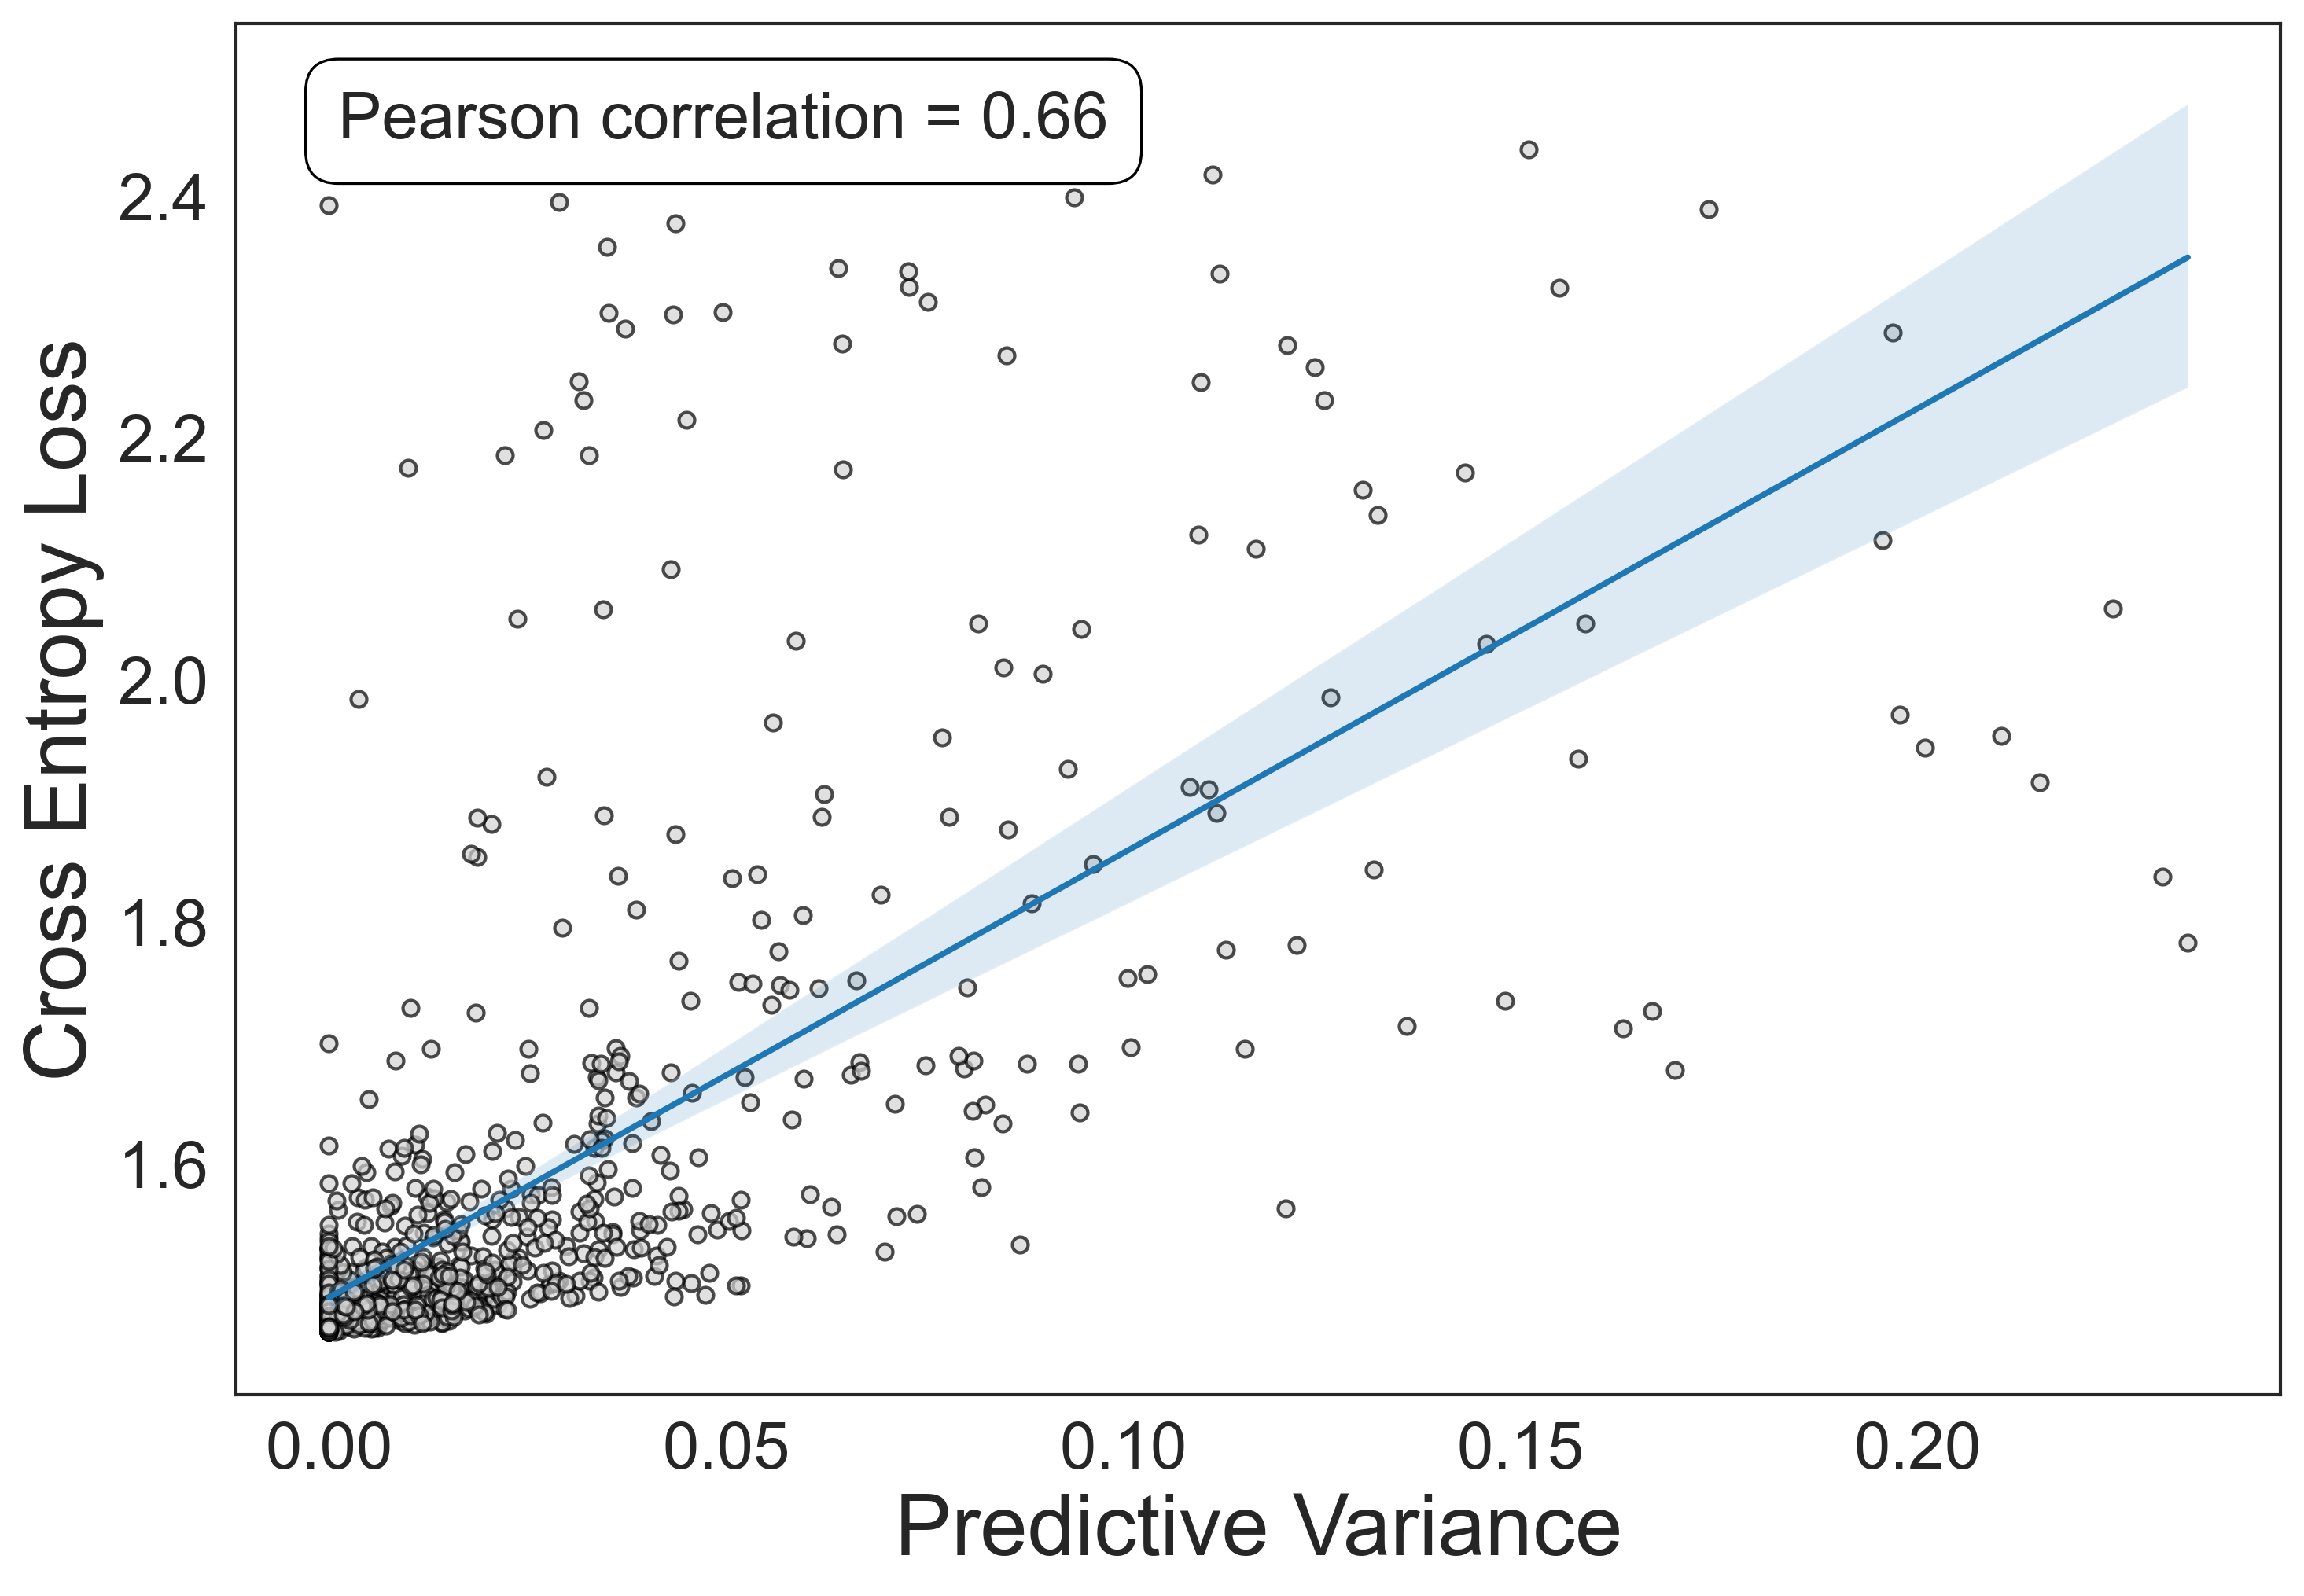

In [6]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats


sns.set_style("white")
sns.set_context("paper", font_scale=1.5)

# Define output directory
output_dir = "/Users/matthewcox/Documents/UCL/MSc/Training_Apps/Results/noise/MNIST/Uncertainty_vs_loss"


fig, ax = plt.subplots(figsize=(10, 7), dpi=300)


method_name = "Prediction_Node"
data_file = os.path.join(output_dir, f"uncertainty_{method_name.lower()}_vs_loss.csv")
data = pd.read_csv(data_file)


sns.regplot(x="uncertainty", y="loss", data=data, 
            scatter_kws={"facecolors": "lightgray", "edgecolors": "black", "alpha": 0.7}, 
            ax=ax)


ax.set_xlabel("Predictive Variance", fontsize=26)
ax.set_ylabel("Cross Entropy Loss", fontsize=26)


ax.tick_params(axis='both', which='major', labelsize=20)  

# Calculate R-squared and Pearson correlation coefficient
slope, intercept, r_value, p_value, std_err = stats.linregress(data["uncertainty"], data["loss"])

# Adding R-squared and Pearson correlation to the plot
textstr = f'Pearson correlation = {round(r_value, 2)}'
props = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white', alpha=1)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
plt.tight_layout()

plt.savefig("/Users/matthewcox/Documents/UCL/MSc/Training_Apps/Latex_Notes/Results_and_Figures/Results/Noise/Unc/regression_plot_of_MNIST_loss_vs_predictive_variance.png")

plt.show()
